## **Problem Overview**

This project focuses on classifying biological kingdoms based on **codon usage patterns** using a **Random Forest Classifier**. Codon usage refers to the frequency of occurrence of different codons (triplets of nucleotides) in a genome, which can vary significantly between different kingdoms of life. Understanding these patterns allows us to identify genomic signatures that are characteristic of specific biological groups.

### **Dataset Description**

The dataset contains codon usage statistics across various species and is structured as follows:

- **Species Information:**
   - `SpeciesID`: Unique identifier for each species.
   - `SpeciesName`: Scientific name of the species.
   - `Kingdom`: Kingdom classification of the species (e.g., `arc`, `bct`, `inv`).

- **Genomic Features:**
   - `Ncodons`: Total number of codons analyzed for each species.
   - **Codon Frequencies:** The dataset contains frequencies of each codon (e.g., `UUU`, `UUC`, `UUA`) representing how often specific nucleotide triplets appear in the genome.

- **Target Variable:**
   - The `Kingdom` column serves as the **target variable** for classification.

### **Kingdom Labels in the Dataset**

1. **arc (Archaea)** – Single-celled microorganisms without a nucleus, often found in extreme environments.
2. **bct (Bacteria)** – Single-celled prokaryotic organisms, widely distributed in various environments.
3. **inv (Invertebrates)** – Animals without a vertebral column, including insects, mollusks, and crustaceans.
4. **mam (Mammals)** – Warm-blooded vertebrates with hair/fur and mammary glands.
5. **phg (Phages)** – Viruses that infect bacteria (bacteriophages).
6. **plm (Plasmodium)** – Parasitic protozoans, including malaria-causing species.
7. **pln (Plants)** – Multicellular photosynthetic organisms.
8. **pri (Primates)** – An order of mammals that includes humans, monkeys, and apes.
9. **rod (Rodents)** – A subgroup of mammals characterized by continuously growing incisors.
10. **vrl (Viruses)** – Infectious agents that replicate inside host cells.
11. **vrt (Vertebrates)** – Animals with a backbone, including mammals, birds, reptiles, amphibians, and fish.

### **Objective**
The goal is to build a robust classification model that can accurately predict the `Kingdom` of a species based on its codon usage patterns. Given the imbalanced nature of the dataset (e.g., limited samples for certain kingdoms like `plm`), specialized techniques such as **class weighting** and **manual oversampling** have been employed to ensure balanced model performance.


In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

### **Data Preprocessing**
The dataset is loaded, and initial preprocessing steps are performed, including cleaning problematic columns (e.g., non-numeric codon usage values) and handling missing data.

In [19]:
df = pd.read_csv("codon_usage.csv")
df.columns




columns_to_drop = ['DNAtype', 'SpeciesID', 'Ncodons', 'SpeciesName']
df = df.drop(columns_to_drop, axis=1)
df


# Convert all columns except 'Kingdom' to numeric, coerce errors to NaN
df.iloc[:, 1:] = df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')

# Drop rows with NaN values
df = df.dropna()

df

label_mapping = {
    'bct': 'bct',  # Eubacteria proper
    'arc': 'arc',  # Archaea
    'plm': 'bct',  # Plasmids to bacteria
    'inv': 'Eukarya',  # Invertebrates
    'mam': 'Eukarya',  # Mammals
    'pln': 'Eukarya',  # Plants
    'pri': 'Eukarya',  # Primates
    'rod': 'Eukarya',  # Rodents
    'vrt': 'Eukarya',  # Vertebrates
    'phg': 'vrl',      #bacteriophage to virus
}

# Example DataFrame

df = pd.DataFrame(df)

# Replace old labels with new labels in the 'Kingdom' column
df['Kingdom'] = df['Kingdom'].replace(label_mapping)

df


# Convert all features to numeric, coerce errors to NaN, and drop rows with NaN values
features = df.drop('Kingdom', axis=1)
features = features.apply(pd.to_numeric, errors='coerce')
features = features.dropna()

/tmp/ipykernel_11916/1223295829.py:1: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("codon_usage.csv")


### **Exploratory Data Analysis (EDA)**
This section visualizes the average codon usage patterns across different kingdoms. Understanding these patterns helps identify key distinguishing features for classification.

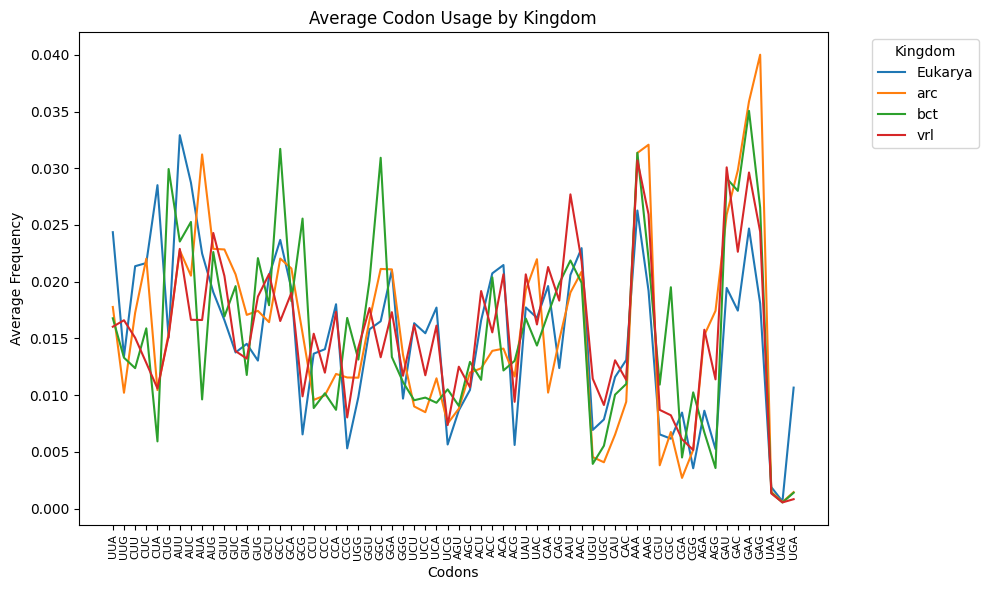

In [20]:
# Group by Kingdom and calculate mean codon usage across numeric columns
grouped_df = df.groupby('Kingdom').mean(numeric_only=True)

# Remove non-codon columns (like 'DNAtype')
grouped_df = grouped_df.drop(columns=['DNAtype', 'SpeciesID', 'Ncodons'], errors='ignore')

# Plot the mean codon usage by Kingdom
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figsize for better visibility
grouped_df.T.plot(ax=ax, legend=True)
ax.set_title('Average Codon Usage by Kingdom')
ax.set_xlabel('Codons')
ax.set_ylabel('Average Frequency')

# Display all x-axis labels
ax.set_xticks(range(len(grouped_df.columns)))
ax.set_xticklabels(grouped_df.columns, rotation=90, fontsize=8)

# Move legend outside the plot
ax.legend(title='Kingdom', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

  Kingdom      UUU      UUC      UUA      UUG      CUU      CUC      CUA  \
0     vrl  0.01654  0.01203  0.00050  0.00351  0.01203  0.03208  0.00100   
1     vrl  0.02714  0.01357  0.00068  0.00678  0.00407  0.02849  0.00204   
2     vrl  0.01974   0.0218  0.01357  0.01543  0.00782  0.01111  0.01028   
3     vrl  0.01775  0.02245  0.01619  0.00992  0.01567  0.01358  0.00940   
4     vrl  0.02816  0.01371  0.00767  0.03679  0.01380  0.00548  0.00473   

       CUG      AUU  ...      CGG      AGA      AGG      GAU      GAC  \
0  0.04010  0.00551  ...  0.00451  0.01303  0.03559  0.01003  0.04612   
1  0.04410  0.01153  ...  0.00136  0.01696  0.03596  0.01221  0.04545   
2  0.01193  0.02283  ...  0.00596  0.01974  0.02489  0.03126  0.02036   
3  0.01723  0.02402  ...  0.00366  0.01410  0.01671  0.03760  0.01932   
4  0.02076  0.02716  ...  0.00604  0.01494  0.01734  0.04148  0.02483   

       GAA      GAG      UAA      UAG      UGA  
0  0.01203  0.04361  0.00251  0.00050  0.00000  
1  0.0

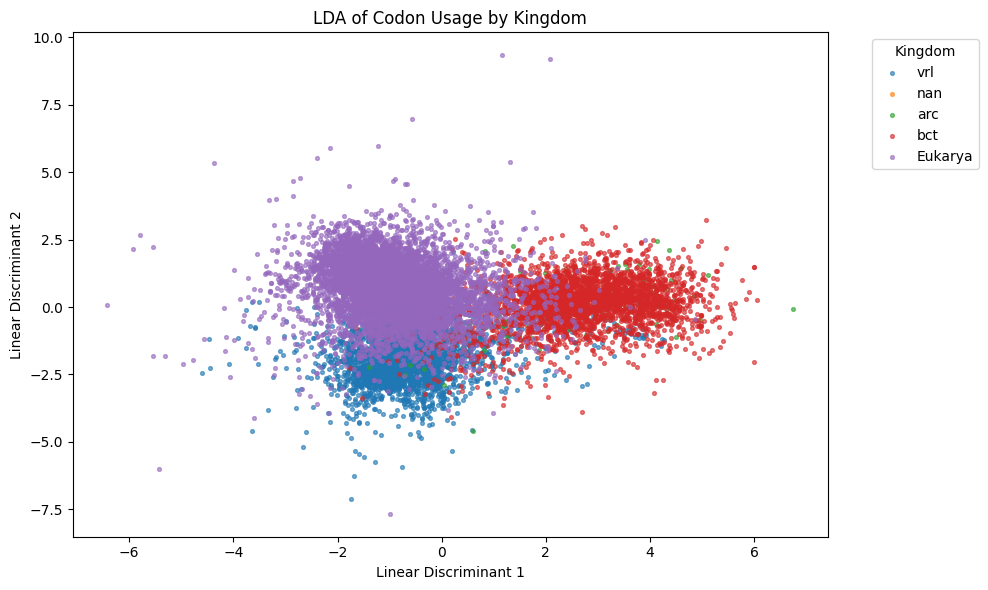

In [21]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt




label_mapping = {
    'bct': 'bct',  # Eubacteria proper
    'arc': 'arc',  # Archaea
    'plm': 'bct',  # Plasmids to bacteria
    'inv': 'Eukarya',  # Invertebrates
    'mam': 'Eukarya',  # Mammals
    'pln': 'Eukarya',  # Plants
    'pri': 'Eukarya',  # Primates
    'rod': 'Eukarya',  # Rodents
    'vrt': 'Eukarya',  # Vertebrates
    'phg': 'vrl',      #bacteriophage to virus
}

# Example DataFrame

#df = pd.DataFrame(df)

# Replace old labels with new labels in the 'Kingdom' column
df['Kingdom'] = df['Kingdom'].replace(label_mapping)

print(df.head())
print(df.info())

print(df['Kingdom'].unique())



# Extract features and target labels
X = df.drop(columns=['Kingdom', 'SpeciesID', 'SpeciesName', 'DNAtype', 'Ncodons'], errors='ignore')
y = df['Kingdom']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply LDA
lda = LinearDiscriminantAnalysis(n_components=2)  # Reduce to 2 linear discriminants
X_lda = lda.fit_transform(X_scaled, y)

# Create a DataFrame for LDA results
lda_df = pd.DataFrame(
    X_lda,
    columns=['LD1', 'LD2']
)
lda_df['Kingdom'] = y

# Plot the LDA results
fig, ax = plt.subplots(figsize=(10, 6))
kingdoms = lda_df['Kingdom'].unique()

for kingdom in kingdoms:
    subset = lda_df[lda_df['Kingdom'] == kingdom]
    ax.scatter(
        subset['LD1'],
        subset['LD2'],
        label=kingdom,
        s=7.5, alpha=0.6
    )

# Add plot title and labels
ax.set_title('LDA of Codon Usage by Kingdom')
ax.set_xlabel('Linear Discriminant 1')
ax.set_ylabel('Linear Discriminant 2')

# Add legend
ax.legend(title='Kingdom', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


### **Class Distribution Analysis**

The number of samples per kingdom is visualized to highlight dataset imbalance. The `plm` Kingdom contains only a small amount of entries (18), while the others are in the hundreds or thousands. Addressing this imbalance is critical for building a fair and robust classifier.

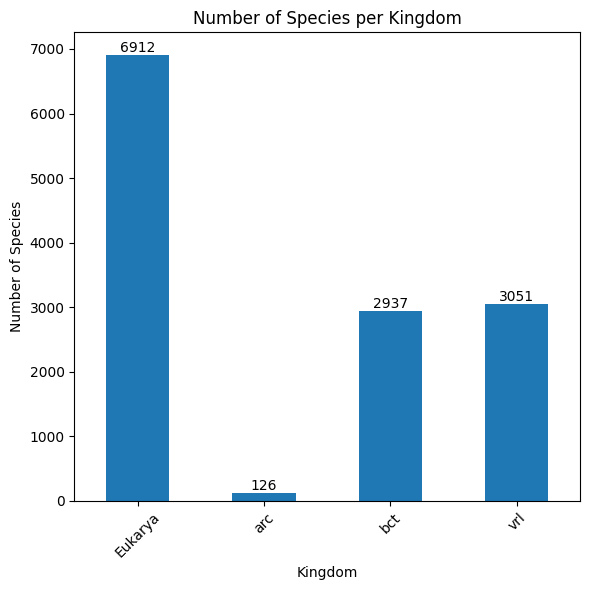

In [22]:
# Count the number of occurrences per Kingdom
kingdom_counts = df['Kingdom'].value_counts().sort_index()

# Plot the counts as a bar plot
fig, ax = plt.subplots(figsize=(6, 6))
kingdom_counts.plot(kind='bar', ax=ax)
#print(kingdom_counts)

# Enhance readability
ax.set_title('Number of Species per Kingdom')
ax.set_xlabel('Kingdom')
ax.set_ylabel('Number of Species')
ax.bar_label(ax.containers[0])  # Display counts on top of bars (matplotlib >= 3.4)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Model Evaluation
This section contains the function for the evaluation of the models. It's in an own section to avoid repetitive code.

In [25]:
def evaluate_model(clf, X_test, y_test, label_encoder, feature_names, top_n_features=10):
    """
    Evaluate the performance of a trained model and visualize key metrics.

    Parameters:
    - clf: Trained classifier
    - X_test: Test features
    - y_test: Test target labels
    - label_encoder: LabelEncoder instance to decode target labels
    - feature_names: List of feature names
    - top_n_features: Number of top features to visualize by importance
    """
    # 1. Predictions and Metrics
    y_pred = clf.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    # 2. Confusion Matrix
    ConfusionMatrixDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        display_labels=label_encoder.classes_,
        cmap='Blues'
    )
    plt.title('Confusion Matrix')
    plt.show()

    # 3. Feature Importance
    if hasattr(clf, 'feature_importances_'):
        importances = clf.feature_importances_
        feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

        # Plot Top N Important Features
        feature_importance_df.head(top_n_features).plot(
            kind='bar', x='Feature', y='Importance', figsize=(6, 4)
        )
        plt.title(f'Top {top_n_features} Important Features')
        plt.show()
    else:
        print("The provided classifier does not support feature importance.")


### **Model Training: Random Forest with Class Weights**

A **Random Forest Classifier** is used to classify kingdoms based on codon usage. Key details:

- **Class Weight Adjustment:** Underrepresented classes are given higher weights to ensure balanced learning.
- **Random Forest Benefits:** Handles high-dimensional data, reduces overfitting, and captures complex relationships in the data.
- **Model Parameters:** Class weights, number of estimators, and tree depth are configured for optimal performance.

This section establishes the baseline model while addressing the class imbalance issue.


Train Class Distribution:
 1     0.224141
9     0.217329
6     0.193629
10    0.159470
2     0.103243
3     0.043945
4     0.016887
8     0.016504
7     0.013817
0     0.009691
5     0.001343
Name: proportion, dtype: float64
Test Class Distribution:
 1     0.224098
9     0.217575
6     0.193784
10    0.159248
2     0.103223
3     0.043745
4     0.016884
8     0.016500
7     0.013814
0     0.009593
5     0.001535
Name: proportion, dtype: float64
Class Weights: {np.int64(0): np.float64(9.38073807380738), np.int64(1): np.float64(0.40558841843088417), np.int64(2): np.float64(0.8805339641770868), np.int64(3): np.float64(2.068678046843986), np.int64(4): np.float64(5.383264462809917), np.int64(5): np.float64(67.67532467532467), np.int64(6): np.float64(0.46950175691503737), np.int64(7): np.float64(6.579545454545454), np.int64(8): np.float64(5.50845665961945), np.int64(9): np.float64(0.41830222757375074), np.int64(10): np.float64(0.5700689202494257)}
Accuracy: 0.9006139677666922
              p

/home/alex/Masters/CO2_ML/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alex/Masters/CO2_ML/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alex/Masters/CO2_ML/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

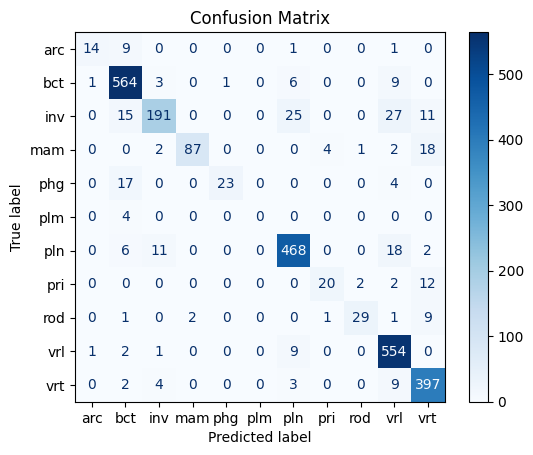

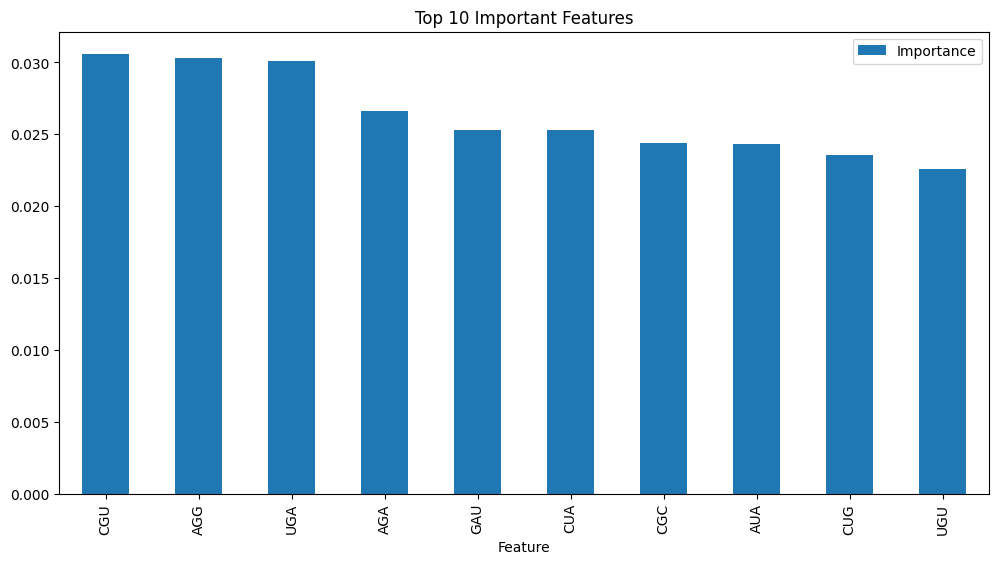

In [37]:
# Separate features and target
X = df.drop(columns=['Kingdom'])
y = df['Kingdom']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Stratified Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

# Check class distribution after split
train_distribution = pd.Series(y_train).value_counts(normalize=True)
test_distribution = pd.Series(y_test).value_counts(normalize=True)
print("Train Class Distribution:\n", train_distribution)
print("Test Class Distribution:\n", test_distribution)

# Compute Class Weights
class_weights = dict(
    zip(
        np.unique(y_train),
        compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    )
)
print("Class Weights:", class_weights)

# Train Random Forest Classifier with Class Weights
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)

evaluate_model(
    clf=clf,
    X_test=X_test,
    y_test=y_test,
    label_encoder=label_encoder,
    feature_names=X.columns,
    top_n_features=10
)

### **Manual Oversampling for Minority Classes**

To address the severe class imbalance, the minority class (`plm`) is manually oversampled. Key reasons:

- **Limited Samples:** `plm` has very few samples, which hampers model learning.
- **Avoid Synthetic Data:** Instead of SMOTE, actual samples are duplicated to improve representation.
- **Stratified Train-Test Split:** Ensures fair representation across training and testing datasets.

This approach enhances the model's ability to identify patterns in the minority class without introducing synthetic bias.


Accuracy: 0.9033000767459708
              precision    recall  f1-score   support

         arc       0.88      0.60      0.71        25
         bct       0.91      0.97      0.94       584
         inv       0.94      0.69      0.80       269
         mam       0.95      0.76      0.84       114
         phg       0.95      0.48      0.64        44
         plm       0.00      0.00      0.00         4
         pln       0.91      0.94      0.92       505
         pri       0.88      0.58      0.70        36
         rod       0.93      0.63      0.75        43
         vrl       0.89      0.99      0.93       567
         vrt       0.89      0.96      0.92       415

    accuracy                           0.90      2606
   macro avg       0.83      0.69      0.74      2606
weighted avg       0.90      0.90      0.90      2606



/home/alex/Masters/CO2_ML/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alex/Masters/CO2_ML/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alex/Masters/CO2_ML/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

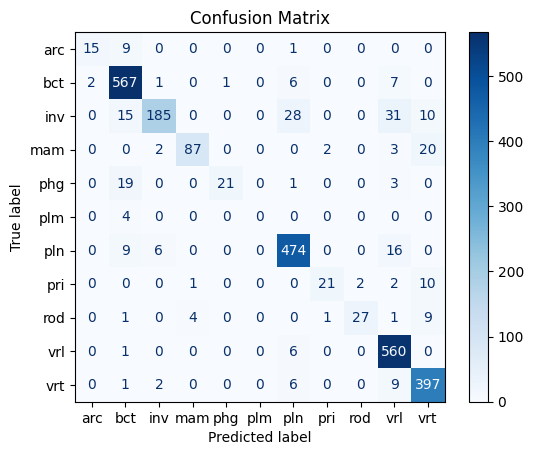

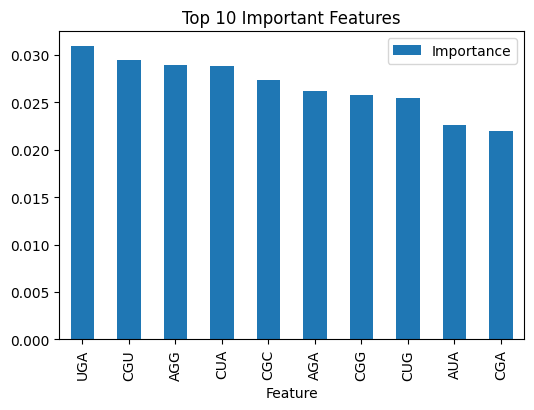

In [39]:
# Train Random Forest Classifier with Class Weights

manual_weights = {
    0: 9.38,  # arc
    1: 0.4,   # bct
    2: 0.88,  # inv
    3: 2.06,  # mam
    4: 5.38,  # phg
    5: 100,   # plm (increase weight manually)
    6: 0.47,  # pln
    7: 6.57,  # pri
    8: 5.5,   # rod
    9: 0.42,  # vrl
    10: 0.57  # vrt
}

clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight=manual_weights)
clf.fit(X_train, y_train)

evaluate_model(
    clf=clf,
    X_test=X_test,
    y_test=y_test,
    label_encoder=label_encoder,
    feature_names=X.columns,
    top_n_features=10
)

### **Hyperparameter Optimization**

Hyperparameters of the Random Forest Classifier are fine-tuned using **GridSearchCV**. Key parameters include:

- **`n_estimators`:** Number of trees in the forest.
- **`max_depth`:** Maximum tree depth to prevent overfitting.
- **`min_samples_split`:** Minimum samples required to split a node.
- **`min_samples_leaf`:** Minimum samples required at leaf nodes.

The objective is to identify the configuration that maximizes performance while maintaining generalizability.


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Best Score: 0.8992306255920088
Accuracy: 0.9029051987767585
              precision    recall  f1-score   support

         arc       0.83      0.60      0.70        25
         bct       0.92      0.97      0.95       584
         inv       0.89      0.73      0.80       269
         mam       0.88      0.77      0.82       114
         phg       0.96      0.61      0.75        44
         plm       1.00      0.93      0.96        14
         pln       0.91      0.92      0.92       505
         pri       0.83      0.56      0.67        36
         rod       0.86      0.56      0.68        43
         vrl       0.88      0.98      0.93       567
         vrt       0.91      0.94      0.93       415

    accuracy                           0.90      2616
   macro avg       0.90      0.78      0.83

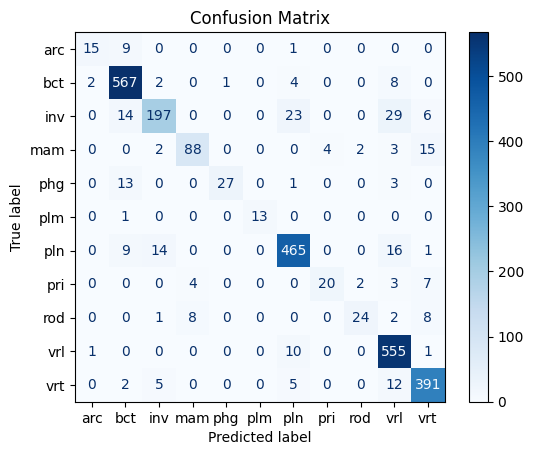

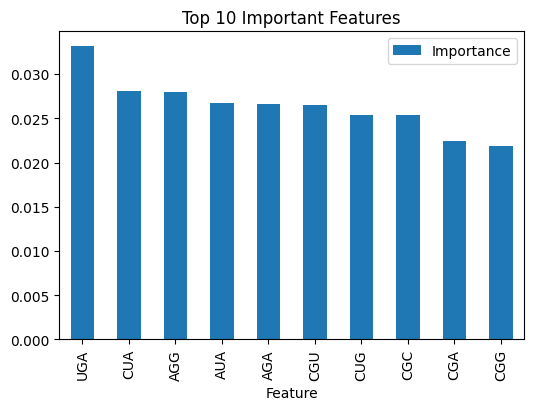

In [41]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced']
}

# Initialize the model
clf = RandomForestClassifier(random_state=42)

# Perform GridSearchCV
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=5,
    scoring='f1_weighted',
    verbose=2,
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Use the best model
best_clf = grid_search.best_estimator_

# Evaluate the tuned model using the evaluate_model function
evaluate_model(
    clf=best_clf,
    X_test=X_test,
    y_test=y_test,
    label_encoder=label_encoder,
    feature_names=X.columns,
    top_n_features=10
)

### **Best Model Parameters**
After hyperparameter tuning, the best-performing model configuration is presented. These parameters balance accuracy and computational efficiency.

`{'class_weight': 'balanced',`
` 'max_depth': 30,`
 `'min_samples_leaf': 2,`
 `'min_samples_split': 5,`
 `'n_estimators': 300}`


Accuracy: 0.9051987767584098
              precision    recall  f1-score   support

         arc       0.82      0.56      0.67        25
         bct       0.92      0.97      0.95       584
         inv       0.89      0.74      0.81       269
         mam       0.86      0.80      0.83       114
         phg       0.96      0.57      0.71        44
         plm       1.00      0.93      0.96        14
         pln       0.92      0.93      0.93       505
         pri       0.87      0.56      0.68        36
         rod       0.85      0.51      0.64        43
         vrl       0.88      0.98      0.93       567
         vrt       0.92      0.94      0.93       415

    accuracy                           0.91      2616
   macro avg       0.90      0.77      0.82      2616
weighted avg       0.90      0.91      0.90      2616



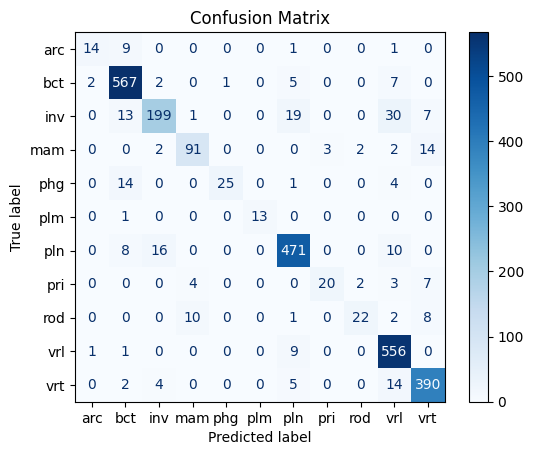

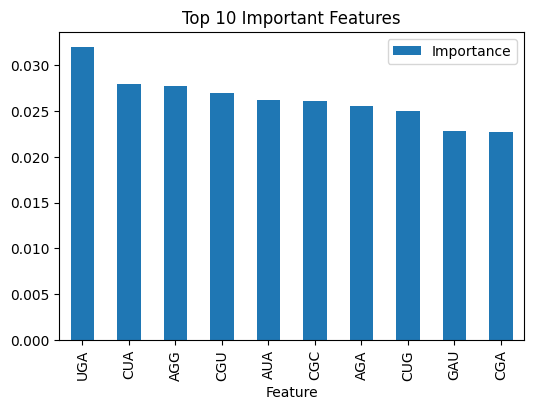

In [40]:
# Manual Oversampling for 'plm'
plm_samples = df[df['Kingdom'] == 'plm']
df_oversampled = pd.concat([df, plm_samples.sample(n=50, replace=True, random_state=42)])

# Recreate Train-Test Split
X = df_oversampled.drop(columns=['Kingdom'])
y = df_oversampled['Kingdom']

X_scaled = scaler.fit_transform(X)
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

# Retrain with the Tuned Hyperparameters
clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=30,
    min_samples_leaf=2,
    min_samples_split=5,
    class_weight='balanced',
    random_state=42
)
clf.fit(X_train, y_train)

evaluate_model(
    clf=clf,
    X_test=X_test,
    y_test=y_test,
    label_encoder=label_encoder,
    feature_names=X.columns,
    top_n_features=10
)

# SMOTE

In [27]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Separate features and target
X = df.drop(columns=['Kingdom'])
y = df['Kingdom']

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-Test Split (BEFORE SMOTE)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Standardize features (only on training data)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE only on the training set
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Verify class distribution after SMOTE
print("Class distribution after SMOTE on training set:")
print(pd.Series(y_train_resampled).value_counts())


Class distribution after SMOTE on training set:
3    5529
0    5529
2    5529
1    5529
Name: count, dtype: int64



Baseline Model Evaluation:
Accuracy: 0.9435917114351496
              precision    recall  f1-score   support

     Eukarya       0.95      0.97      0.96      1383
         arc       0.92      0.44      0.59        25
         bct       0.94      0.93      0.94       588
         vrl       0.93      0.91      0.92       610

    accuracy                           0.94      2606
   macro avg       0.93      0.81      0.85      2606
weighted avg       0.94      0.94      0.94      2606



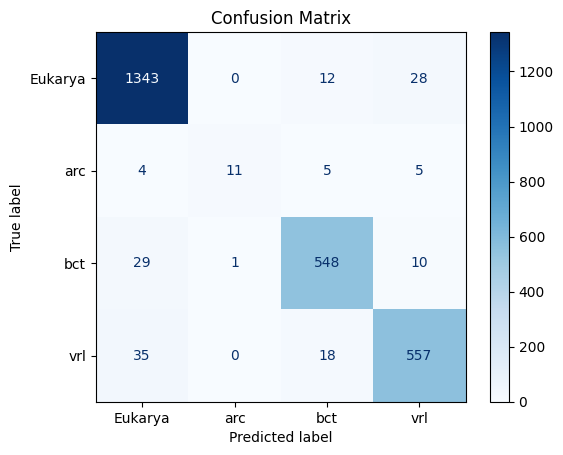

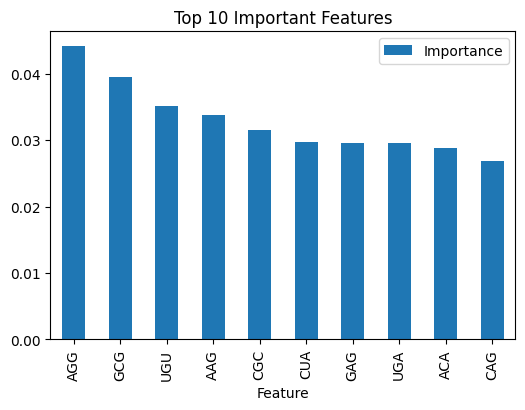

In [28]:
# Train a Baseline Random Forest Model
rf_clf_baseline = RandomForestClassifier(random_state=42)  # Default parameters
rf_clf_baseline.fit(X_train, y_train)

# Evaluate the Baseline Model
print("\nBaseline Model Evaluation:")
evaluate_model(
    clf=rf_clf_baseline,
    X_test=X_test,
    y_test=y_test,
    label_encoder=label_encoder,
    feature_names=X.columns
)


Starting GridSearchCV...
Fitting 5 folds for each of 81 candidates, totalling 405 fits

Best Parameters: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Best F1 Score (Weighted): 0.8963903836022489

Best Model Evaluation:
Accuracy: 0.9090560245587107
              precision    recall  f1-score   support

         arc       0.89      0.64      0.74        25
         bct       0.93      0.96      0.94       584
         inv       0.88      0.77      0.82       269
         mam       0.96      0.78      0.86       114
         phg       0.97      0.66      0.78        44
         plm       0.00      0.00      0.00         4
         pln       0.91      0.93      0.92       505
         pri       0.79      0.64      0.71        36
         rod       0.81      0.70      0.75        43
         vrl       0.89      0.98      0.93       566
         vrt       0.92      0.94      0.93       416

    accuracy                   

/home/alex/Masters/CO2_ML/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alex/Masters/CO2_ML/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alex/Masters/CO2_ML/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

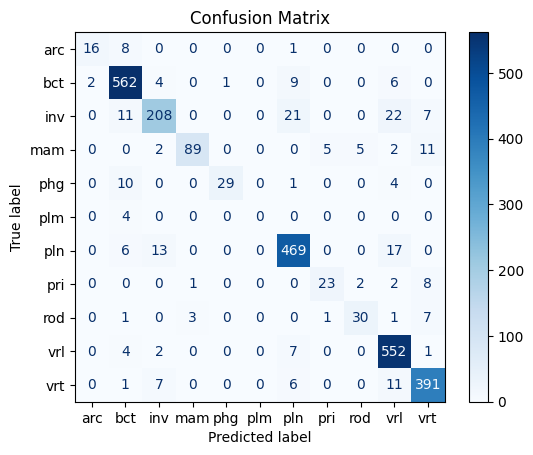

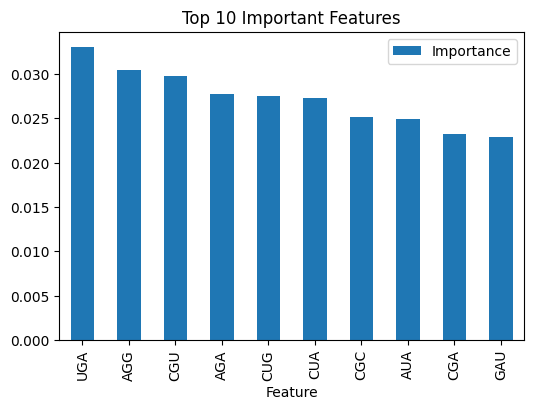

In [14]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced']
}

# Perform GridSearchCV for Hyperparameter Optimization
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='f1_weighted',
    verbose=2,
    n_jobs=-1
)

print("\nStarting GridSearchCV...")
grid_search.fit(X_train, y_train)

# Retrieve Best Model and Parameters
print("\nBest Parameters:", grid_search.best_params_)
print("Best F1 Score (Weighted):", grid_search.best_score_)

# Evaluate the Best Model
best_rf_clf = grid_search.best_estimator_
print("\nBest Model Evaluation:")
evaluate_model(
    clf=best_rf_clf,
    X_test=X_test,
    y_test=y_test,
    label_encoder=label_encoder,
    feature_names=X.columns
)



Final Model Evaluation:
Accuracy: 0.943207981580967
              precision    recall  f1-score   support

     Eukarya       0.98      0.95      0.96      1383
         arc       0.76      0.88      0.81        25
         bct       0.93      0.94      0.93       588
         vrl       0.90      0.94      0.92       610

    accuracy                           0.94      2606
   macro avg       0.89      0.93      0.91      2606
weighted avg       0.94      0.94      0.94      2606



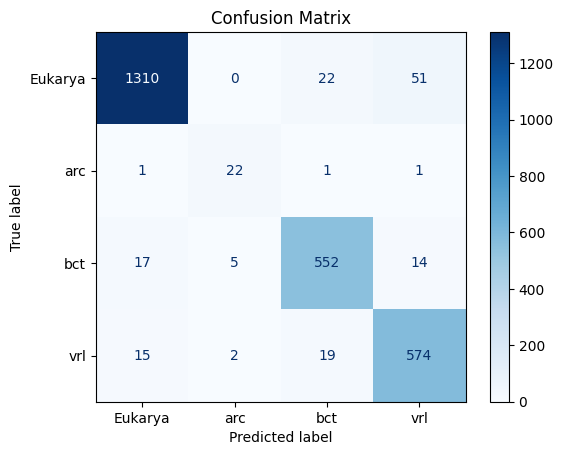

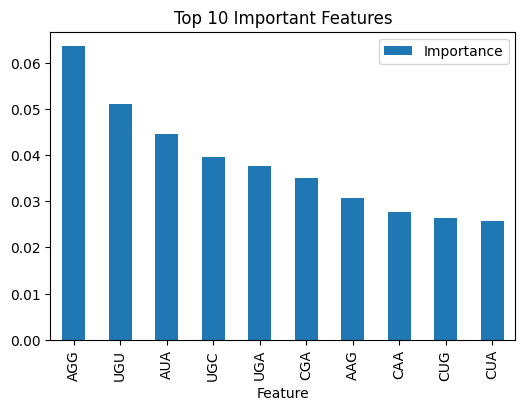

In [29]:
# Train the final model with best parameters
final_rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_leaf=2,
    min_samples_split=10,
    class_weight='balanced',
    random_state=42
)

# Fit the final model on resampled training data
final_rf_clf.fit(X_train_resampled, y_train_resampled)

# Evaluate the final model
print("\nFinal Model Evaluation:")
evaluate_model(
    clf=final_rf_clf,
    X_test=X_test_scaled,  # Use the scaled test data
    y_test=y_test,
    label_encoder=label_encoder,
    feature_names=X.columns  # Match the original feature names
)

# Support Vector Machine (SVM)


Initial SVM Model Evaluation:
Accuracy: 0.965464313123561
              precision    recall  f1-score   support

     Eukarya       0.99      0.97      0.98      1383
         arc       0.82      0.92      0.87        25
         bct       0.97      0.95      0.96       588
         vrl       0.93      0.98      0.95       610

    accuracy                           0.97      2606
   macro avg       0.93      0.95      0.94      2606
weighted avg       0.97      0.97      0.97      2606



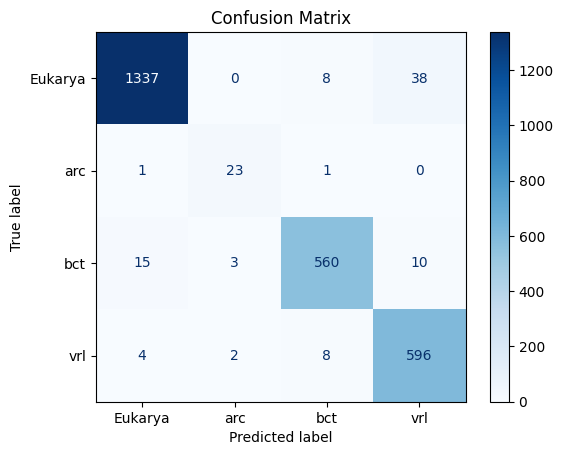

The provided classifier does not support feature importance.


In [30]:
svm_clf = SVC(random_state=42)  # Default parameters
svm_clf.fit(X_train_resampled, y_train_resampled)

# Evaluate Initial SVM Model
print("\nInitial SVM Model Evaluation:")
evaluate_model(
    clf=svm_clf,
    X_test=X_test_scaled,
    y_test=y_test,
    label_encoder=label_encoder,
    feature_names=X.columns
)


Starting GridSearchCV for SVM...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best Parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Best F1 Score (Weighted): 0.9849315102433872

Best SVM Model Evaluation:
Accuracy: 0.9497313891020721
              precision    recall  f1-score   support

         arc       0.81      0.84      0.82        25
         bct       0.96      0.97      0.97       584
         inv       0.92      0.93      0.92       269
         mam       0.90      0.89      0.90       114
         phg       0.94      0.77      0.85        44
         plm       0.67      0.50      0.57         4
         pln       0.95      0.96      0.95       505
         pri       0.77      0.67      0.72        36
         rod       0.83      0.79      0.81        43
         vrl       0.96      0.98      0.97       566
         vrt       0.98      0.97      0.97       416

    accuracy                           0.95      2606
   macro avg       0.88      0.84 

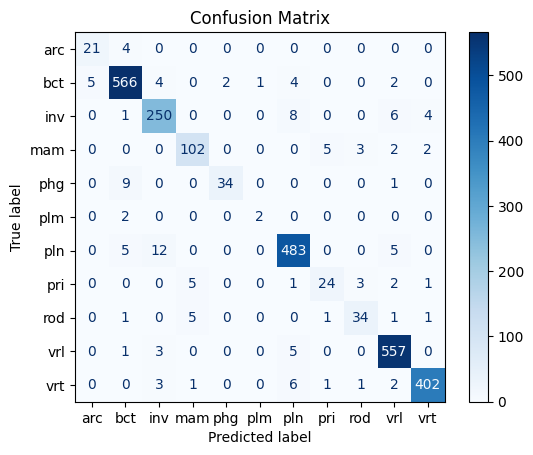

The provided classifier does not support feature importance.


In [18]:
# Define the parameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.001],
    'kernel': ['linear', 'rbf', 'poly']
}

# Perform GridSearchCV for Hyperparameter Optimization
grid_search_svm = GridSearchCV(
    estimator=SVC(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='f1_weighted',
    verbose=2,
    n_jobs=-1
)

print("\nStarting GridSearchCV for SVM...")
grid_search_svm.fit(X_train_resampled, y_train_resampled)

# Retrieve Best Parameters
print("\nBest Parameters:", grid_search_svm.best_params_)
print("Best F1 Score (Weighted):", grid_search_svm.best_score_)

# Evaluate the Best SVM Model
best_svm_clf = grid_search_svm.best_estimator_
print("\nBest SVM Model Evaluation:")
evaluate_model(
    clf=best_svm_clf,
    X_test=X_test_scaled,
    y_test=y_test,
    label_encoder=label_encoder,
    feature_names=X.columns
)



Final SVM Model Evaluation:
Accuracy: 0.9643131235610131
              precision    recall  f1-score   support

     Eukarya       0.97      0.98      0.98      1383
         arc       0.88      0.84      0.86        25
         bct       0.96      0.93      0.94       588
         vrl       0.95      0.96      0.95       610

    accuracy                           0.96      2606
   macro avg       0.94      0.93      0.93      2606
weighted avg       0.96      0.96      0.96      2606



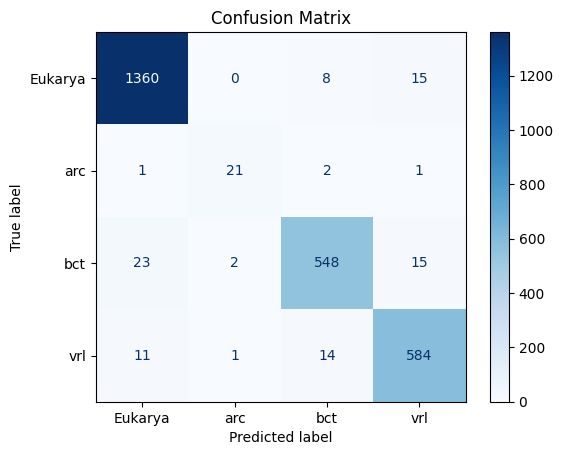

The provided classifier does not support feature importance.


In [31]:
# Train the final SVM model with best parameters
final_svm_clf = SVC(
    C=100,
    gamma='scale',
    kernel='rbf',
    random_state=42
)

# Fit the final model on resampled training data
final_svm_clf.fit(X_train_resampled, y_train_resampled)

# Evaluate the final model
print("\nFinal SVM Model Evaluation:")
evaluate_model(
    clf=final_svm_clf,
    X_test=X_test_scaled,  # Use the scaled test data
    y_test=y_test,
    label_encoder=label_encoder,
    feature_names=X.columns
)


## **Evaluation of Using ChatGPT for the Assignment**

### **Interface/Version of ChatGPT Tried**
For this project, we used **ChatGPT-4 via the website interface**. The tool provided quick responses and maintained context effectively across a long session, which was useful for iterative problem-solving.
- **Pros:**
  - Responses were well-structured, making it easy to integrate into the workflow.
  - Effective at combining high-level explanations with detailed code implementations when needed.
- **Cons:**
  - Occasionally verbose and required filtering to identify the most relevant parts.
  - Some repetitive responses, especially for previously clarified points.

### **Effective and Ineffective Prompts**
- **Prompts That Worked Well:**
  - Precise, task-oriented prompts like "Implement SVM with SMOTE and hyperparameter optimization" delivered complete, actionable code with minimal need for modification.
  - Requests for conceptual comparisons, e.g., "When to use GridSearchCV vs. Bayesian Optimization," yielded concise and accurate distinctions.
- **Prompts That Did Not Work Well:**
  - Overly broad or vague prompts like "What is the best optimization method?" led to generalized answers that required follow-ups to refine.
  - Asking for simplified workflows sometimes resulted in oversimplification, requiring iterative clarifications.

### **Workflows Tried and Recommendations**
- **Workflows Tried:**
  - I frequently began with high-level conceptual questions to outline a solution, followed by targeted prompts for specific implementations. For example, I asked for a pipeline integrating SMOTE and Random Forest, then refined it step-by-step.
  - I used ChatGPT for debugging when encountering errors, providing detailed error messages and relevant code snippets. This was especially useful for correcting issues like data leakage in train-test splits.
- **Recommendation:**
  - ChatGPT works best with a structured workflow: Begin with specific objectives, verify outputs iteratively, and cross-check results to ensure correctness.

### **Ensuring Code Correctness**
I ensured code correctness through multiple methods:
1. Cross-validated outputs against expected results. For example, after applying SMOTE, I checked class distributions and verified model performance on unseen test data.
2. Tested implementations in my local environment to confirm compatibility and correctness, adjusting minor details like variable mismatches or function arguments.
3. Applied metrics (e.g., accuracy, F1-score) and confusion matrices to verify that model behavior matched theoretical expectations.

### **General Impression of Usefulness/Problems**
- **Usefulness:**
  - ChatGPT was a valuable assistant, particularly for implementing standard techniques like SMOTE, hyperparameter optimization, and ensemble methods. It saved significant time by providing ready-to-run code and enabling iterative refinement of solutions.
  - Its ability to explain concepts like the differences between GridSearchCV and RandomizedSearchCV reinforced my understanding of when to use specific techniques.
- **Problems:**
  - While the tool’s outputs were generally accurate, verbose responses occasionally slowed the process by requiring manual filtering of the most relevant information.
  - In cases of ambiguous prompts, responses were overly generic, requiring me to rephrase for clarity.

### **Final Thoughts**
Overall, ChatGPT significantly enhanced the efficiency of solving this assignment. It allowed us to focus on critical aspects of the workflow, like model evaluation and result interpretation, by streamlining coding and debugging tasks. Its performance aligns well with tasks requiring rapid prototyping and iterative improvements. While it’s not without limitations—like verbosity or handling vague prompts—it is a powerful tool for complementing domain knowledge and enhancing productivity.
